In [1]:
import numpy as np
import pandas as pd
import re
import spacy
import jsonlines
from spacy import displacy
from spacy.symbols import nsubj, VERB
from spacy.pipeline import EntityRuler
from spacy.matcher import Matcher
from spacy.tokens import Span

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from collections import Counter
import string
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize 
from nltk import ngrams

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class job_skills_parser:

    def __init__(self,nlp):
        nlp=nlp
        config = {"phrase_matcher_attr": None, "validate": True,
                  "overwrite_ents": False, "ent_id_sep": "||", }

        ruler = nlp.add_pipe("entity_ruler", config=config)
        ruler.from_disk('padrões')
        self.rules = ruler.patterns
        
    def update_patterns(self,new_patterns):
        ruler.add_patterns(patterns)
        self.rules = ruler.patterns
        ruler.to_disk('padrões')

    def fit_text(self, text):
        text = text.lower()
        text = text.replace('.', '. ')
        text = text.replace(',', ', ')
        text = text.replace(';', '; ')
        text = text.replace(':', ': ')
        text = text.replace(' . ', ' ')
        text = text.replace('  ', ' ')
        self.doc = nlp(text)

    def show_skills(self):
        displacy.render(self.doc, style="ent", jupyter=True)

    def get_skills(self):
        skills = [(ent.text, ent.label_)
                  for ent in self.doc.ents
                  if ent.label_ in ['JOB_DESC', 'hard_skills', 'formação', 'extra_skills', 'sistemas', 'experiencia','linguagens']]

        return skills



In [3]:
bad_words = ['gender', 'experience', 'application', 'Apply', 'salary', 'todos', 'os', 'company', 'identity', 'sexual', 'orientation',
            'de', 'orientação', 'sexual', 'gênero', 'committed', 'toda', 'client', 'conhecimento','completo',
            'world', 'year', 'save', 'São', 'Paulo', 'information', 'e', 'orientação', 'sexual', 'equal', 'oppotunity', 'ambiente', 'will',
            'Experiência', 'national origin', 'todas', 'work', 'de', 'da', 'years', 'pessoa', 'clients', 'Plano', 'creating',
            'employer', 'saúde', 'em', 'working', 'pessoas', 'mais', 'data', 'people', 'dia', 'one', 'knowledges', 'plataforma',
            'ou', 'benefício', 'para', 'software', 'opportunity', 'tecnologia', 'você', 'mais', 'solution', 'national', 'origin',
            'trabalhar', 'option', 'negócio', 'empresa', 'o', 'sicence', 'team', 'é', 'veteran', 'status', 'etc', 'raça', 'cor', 'belive',
            'nossa', 'uma', 'como', 'Scientist', 'ferramenta', 'projeto', 'que', 'job', 'benefícios', 'knowledge', 'toll', 's',
            'desconto', 'cultura', 'serviço', 'time', 'se', 'solutions', 'mercado', 'das', 'somos', 'problema', 'mundo', 'race', 'color',
            'vaga', 'pelo', 'ser', 'show', 'Seguro', 'Se', 'um', 'Um', 'tool', 'regard', 'without', 'make', 'ao', 'técnica', 'life',
            'interested', 'diversidade', 'proud', 'ability', 'sobre', 'options', 'using', 'área', 'nosso', 'na', 'seu', 'product', 'produto',
            'building', 'skill', 'model', 'religion', 'Share', 'receive', 'consideration', 'Aqui', 'vida', 'ferramentas', 'Vale', 'Refeição',
            'Strong', 'Pay', 'range', 'available', 'part', 'trabalho', 'Alimentação', 'employment', 'qualified', 'applicants', 'gympass',
            'está', 'comprometida', 'forma', 'Transporte', 'Yes', 'gente', 'melhor', 'lugar', 'believe', 'moment', 'próximo', 'deasafio',
             'fazer','apuração','apurar','atuação','atuar','realização','realizar','elaoração','elaborar',
            'planejamento','planejar','apoio','apoiar','facilidade','revisão','revisar','execução','executar',
            'análise','analisar','validação','validar','participação','participar','confecção','confeccionar',
            'consolidação','consolidar','desenvolvimento','desenvolver','criação','criar','auxílio','avançado','intermediário'
            'auxiliar','acompanhamento','acompanhar','controle','controlar','revisão','revisar','básico','fluente',
            'formação','formação','formar','graduação','graduar','superior','cursar','cursando','graduação','graduar',
            'vivencia','vivência','atuar','atuação','experiencia','experiência','conhecimento','conhecer','habilidade',
            'dos', 'oportunidade', 'idade', 'new', 'Try', 'Premium', 'deficiência', 'sempre', 'criar', 'employee', 'problemas', 'unavailable',
            'Brasil', 'dado', 'hiring', 'trends', 'equipe', 'recent', 'temos', 'build', 'career', 'nós', 'diferencial', 'ma',
            'total', 'oferecemos', 'contato', 'tem', 'não', 'free', 'Full','of','to','is','avançado','conhecimentos',

            'capacidade','entendimento','entender','facilidade','avançado','intermediário','intermediario','basico']

stopw = 'de a o que e do da em um para é com não uma os no se na por mais as dos como mas foi ao ele das tem à seu sua ou ser quando muito há nos já está eu também só pelo pela até isso ela entre era depois sem mesmo aos ter seus quem nas me esse eles estão você tinha foram essa num nem suas meu às minha têm numa pelos elas havia seja qual será nós tenho lhe deles essas esses pelas este fosse dele tu te vocês vos lhes meus minhas teu tua teus tuas nosso nossa nossos nossas dela delas esta estes estas aquele aquela aqueles aquelas isto aquilo estou está estamos estão estive esteve estivemos estiveram estava estávamos estavam estivera estivéramos esteja estejamos estejam estivesse estivéssemos estivessem estiver estivermos estiverem hei há havemos hão houve houvemos houveram houvera houvéramos haja hajamos hajam houvesse houvéssemos houvessem houver houvermos houverem houverei houverá houveremos houverão houveria houveríamos houveriam sou somos são era éramos eram fui foi fomos foram fora fôramos seja sejamos sejam fosse fôssemos fossem for formos forem serei será seremos serão seria seríamos seriam tenho tem temos tém tinha tínhamos tinham tive teve tivemos tiveram tivera tivéramos tenha tenhamos tenham tivesse tivéssemos tivessem tiver tivermos tiverem terei terá teremos terão teria teríamos teriam'.split()

stopw = [*stopw,*bad_words]

In [4]:
def tokenize(text):
    WNLTokens = []
    chars = []
    
    WNLemmatizer = WordNetLemmatizer()
    for ch in text:
        if ch not in string.punctuation:
            chars.append(ch)
        else:
            chars.append(' ')
    txt = ''.join(chars)        
        
    tokens = word_tokenize(txt)
    for t in tokens:
        WNLTokens.append(WNLemmatizer.lemmatize(t))
    
    return WNLTokens

def get_frequency(countvec,sent_list):
    
    dtm = countvec.fit_transform(sent_list)
    word_list = countvec.get_feature_names_out()

    # Added [0] here to get a 1d-array for iteration by the zip function. 
    count_list = np.asarray(dtm.sum(axis=0))[0]

    word_vec = pd.DataFrame(zip(word_list, count_list))
    word_vec = word_vec.sort_values(1,ascending=False)
    word_vec = word_vec.rename(columns={0:'word',1:'frequency'})
    
    return word_vec

In [5]:
#carregando o modelo com a inguagem PT large
nlp = spacy.load("pt_core_news_lg")
modelo = job_skills_parser(nlp)

In [6]:
df = pd.read_excel('LinkedIn Planejamento Financeiro 10.02.xlsx')
df['count'] = 1
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    348 non-null    int64  
 1   job           319 non-null    object 
 2   description   348 non-null    object 
 3   candidatos    241 non-null    float64
 4   empresa       347 non-null    object 
 5   local         348 non-null    object 
 6   regime        325 non-null    object 
 7   tipo empresa  325 non-null    object 
 8   jobp          348 non-null    object 
 9   tamanho       244 non-null    object 
 10  atuação       292 non-null    object 
 11  count         348 non-null    int64  
dtypes: float64(1), int64(2), object(9)
memory usage: 32.8+ KB


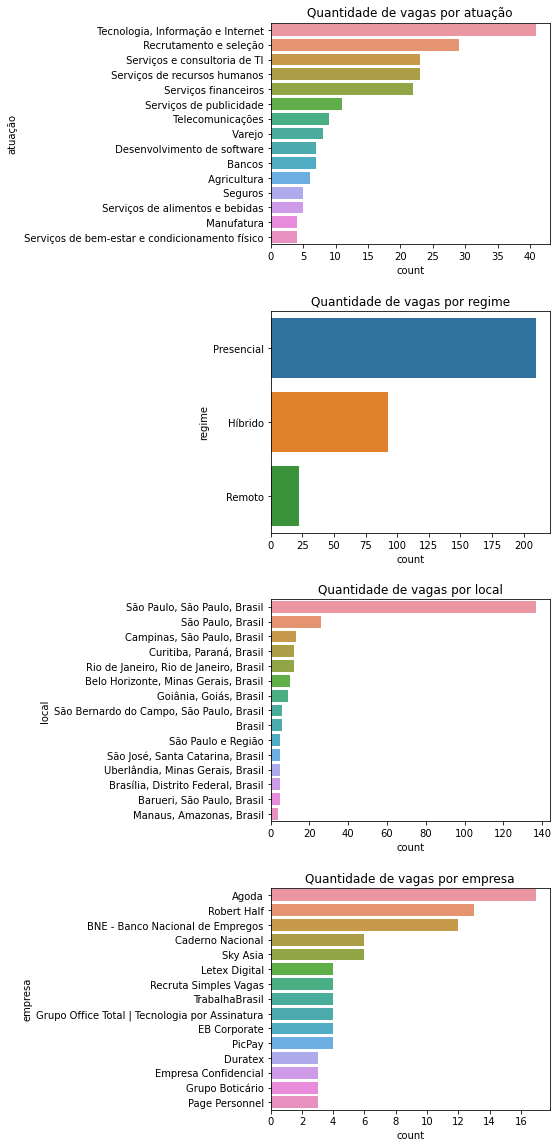

In [7]:
parametros_plot = ['atuação','regime','local','empresa']


fig, axes = plt.subplots(len(parametros_plot),figsize=(5,20))
plt.subplots_adjust(wspace=5,hspace=.3)
n=0
for compare in parametros_plot:
    df_bar = data=df.groupby([compare],as_index=False)['count'].sum().sort_values('count',ascending=False)
    sns.barplot(ax=axes[n],data=df_bar.head(15),
            y=compare,
            x='count').set_title(f'Quantidade de vagas por {compare}')
    n+=1

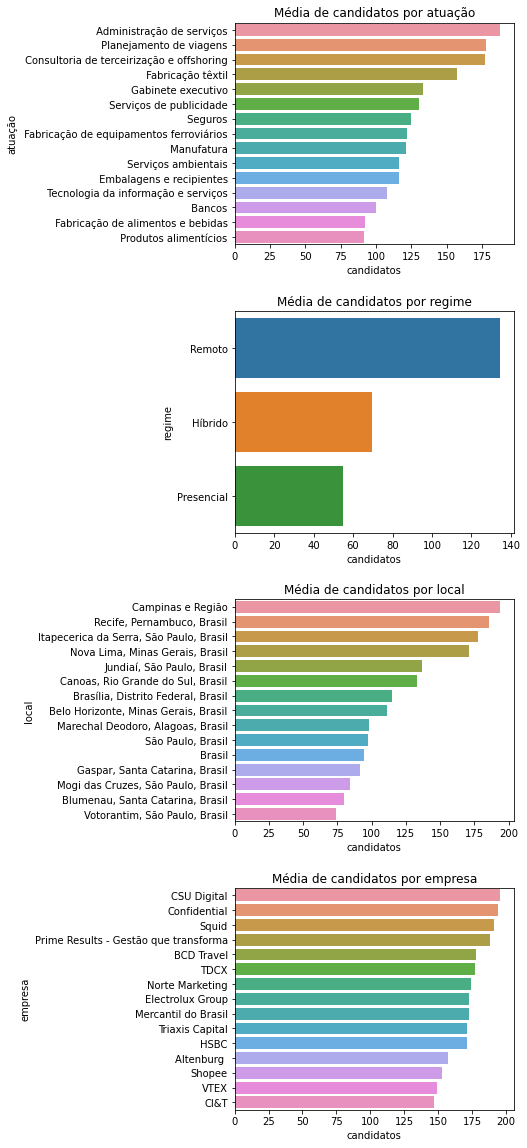

In [8]:
parametros_plot = ['atuação','regime','local','empresa']

fig, axes = plt.subplots(len(parametros_plot),figsize=(5,20))
plt.subplots_adjust(wspace=5,hspace=.3)
n=0
for compare in parametros_plot:
    df_bar = data=df.groupby([compare],as_index=False)['candidatos'].mean().sort_values('candidatos',ascending=False)
    sns.barplot(ax=axes[n],data=df_bar.head(15),
            y=compare,
            x='candidatos').set_title(f'Média de candidatos por {compare}')
    n+=1

<AxesSubplot:xlabel='tamanho', ylabel='candidatos'>

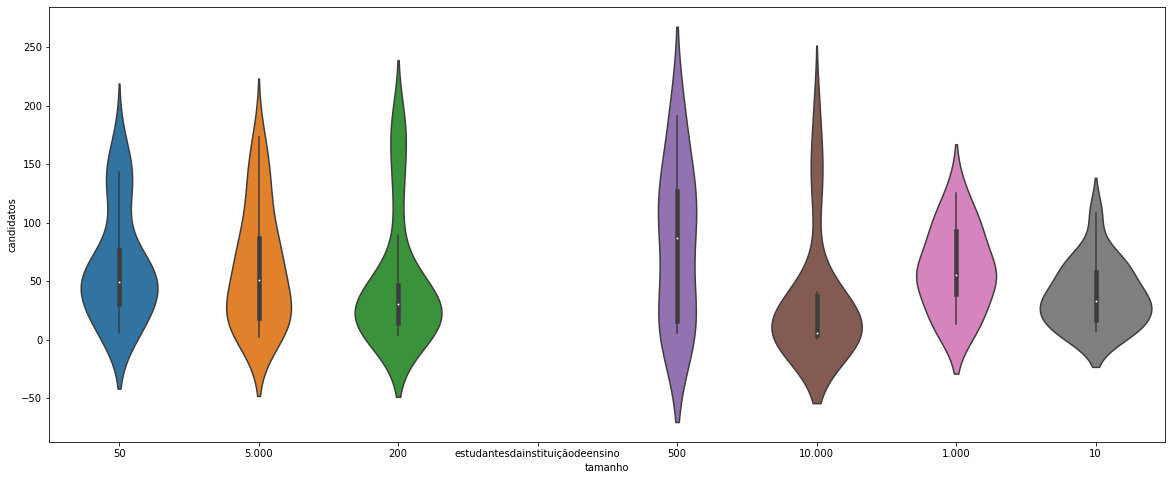

In [9]:
plt.figure(figsize=(20,8))
sns.violinplot(data=df,
              x='tamanho',
              y='candidatos')

<AxesSubplot:xlabel='tamanho', ylabel='count'>

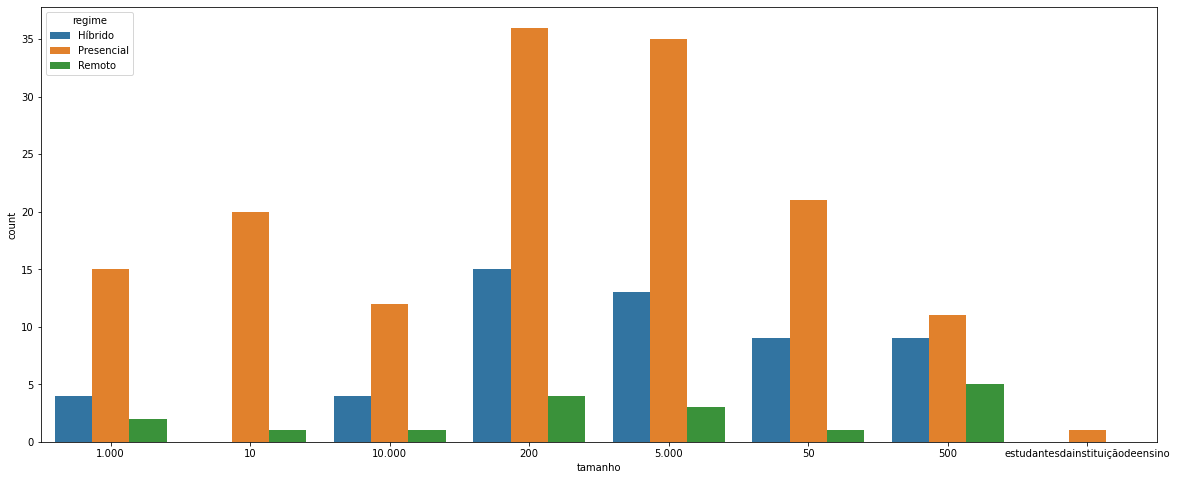

In [10]:
plt.figure(figsize=(20,8))
df_plot = df.groupby(['tamanho','regime'],as_index=False)['count'].sum()
sns.barplot(data=df_plot,
              x='tamanho',
              y='count',
              hue='regime')

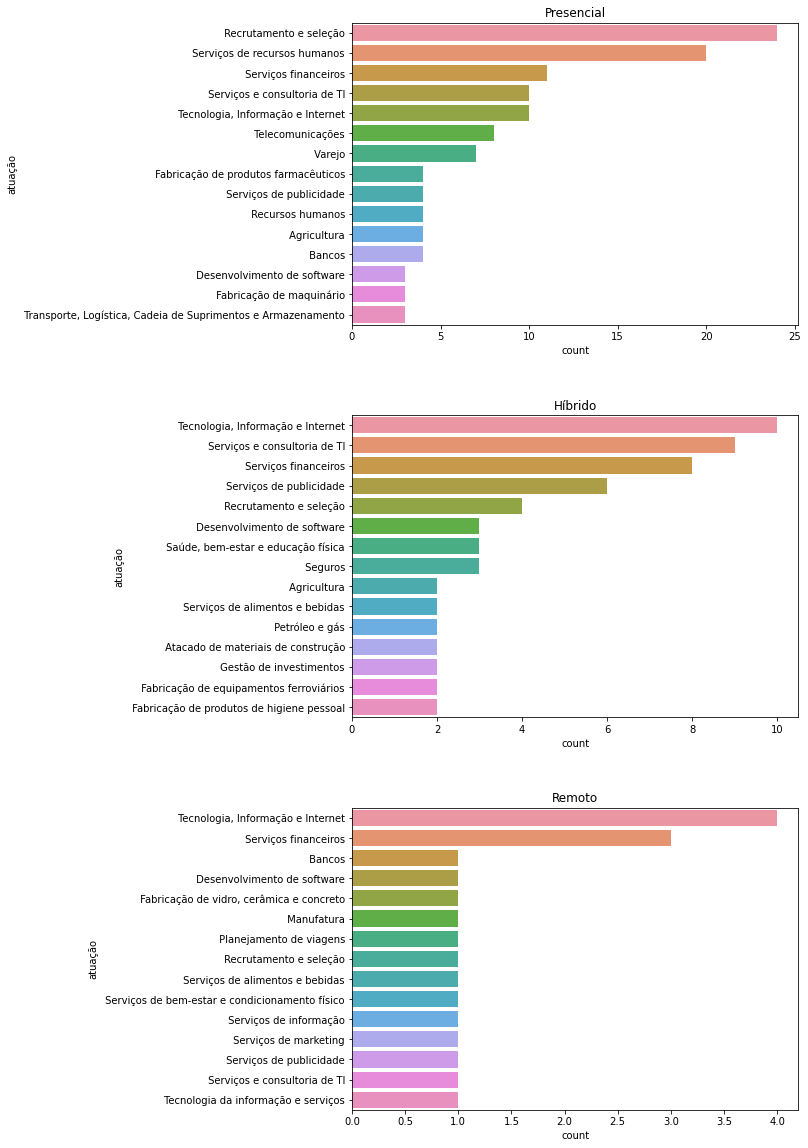

In [11]:
regimes = ['Presencial','Híbrido','Remoto']

fig, axes = plt.subplots(3,figsize=(8,20))
plt.subplots_adjust(wspace=5,hspace=.3)

df_plot = df.groupby(['atuação','regime'],as_index=False)['count'].sum()

n=0
for regime in regimes:
    sns.barplot(ax=axes[n],data=df_plot[df_plot['regime'] == regime].sort_values('count',ascending=False).head(15),
              y='atuação',
              x='count').set_title(regime)
    n+=1

In [12]:
df['len'] = df['description'].str.len()
df = df[df['len']>300].reset_index()

jobs = df['description']

In [13]:
all_skills = {'skills':[],'tipo':[],'cargo':[],'regime':[],'candidatos':[],'atuação':[]}
n=0
for job in jobs:
    modelo.fit_text(job)
    for skill,tipo in modelo.get_skills():
        all_skills['skills'].append(skill)
        all_skills['tipo'].append(tipo)
        all_skills['regime'].append(df['regime'][n])
        all_skills['cargo'].append(df['jobp'][n])
        all_skills['candidatos'].append(df['candidatos'][n])
        all_skills['atuação'].append(df['atuação'][n])
    n+=1
all_skills = pd.DataFrame(all_skills)   

In [14]:
#definir os CountVectorizers
Cont = CountVectorizer(max_df=0.95,min_df=2,stop_words=stopw,tokenizer=tokenize,ngram_range=(1, 2))
ContV = CountVectorizer(max_df=0.95,min_df=2,stop_words=stopw,tokenizer=tokenize,ngram_range=(1, 1))
ContV2 = CountVectorizer(max_df=0.95,min_df=2,stop_words=stopw,tokenizer=tokenize,ngram_range=(2, 2))

In [15]:
df_skills = pd.DataFrame()

for skill_type in list(set(all_skills['tipo'])):

    try:
        result1 = pd.DataFrame()
        result1 = get_frequency(ContV,all_skills[all_skills['tipo'] == skill_type]['skills'])
        result1['tipo'] = skill_type
        result1['ngram'] = 'unigram'
        
        result2 = pd.DataFrame()
        result2 = get_frequency(ContV2,all_skills[all_skills['tipo'] == skill_type]['skills'])
        result2['tipo'] = skill_type
        result2['ngram'] = 'bigram'
    except: pass
    
    df_skills = pd.concat([df_skills,result1,result2],ignore_index=True)

C:\Users\caiozas\Anaconda39\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['alimentação', 'applicant', 'apply', 'aqui', 'brasil', 'es', 'forum', 'full', 'paulo', 'pay', 'plano', 'premium', 'refeição', 'scientist', 'seguro', 'share', 'strong', 'transporte', 'trend', 'try', 'vale', 'yes'] not in stop_words.
  warnings.warn(
C:\Users\caiozas\Anaconda39\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['alimentação', 'applicant', 'apply', 'aqui', 'brasil', 'es', 'forum', 'full', 'paulo', 'pay', 'plano', 'premium', 'refeição', 'scientist', 'seguro', 'share', 'strong', 'transporte', 'trend', 'try', 'vale', 'yes'] not in stop_words.
  warnings.warn(


In [16]:
df_skills

,word,frequency,tipo,ngram
0,financeiro,25,experiencia,unigram
1,financeira,20,experiencia,unigram
2,finanças,17,experiencia,unigram
3,processos,13,experiencia,unigram
4,áreas,11,experiencia,unigram
...,...,...,...,...
1863,formado brilho,2,formação,bigram
1864,formado engajadas,2,formação,bigram
1865,formados negócios,2,formação,bigram
1866,negócios diversificados,2,formação,bigram


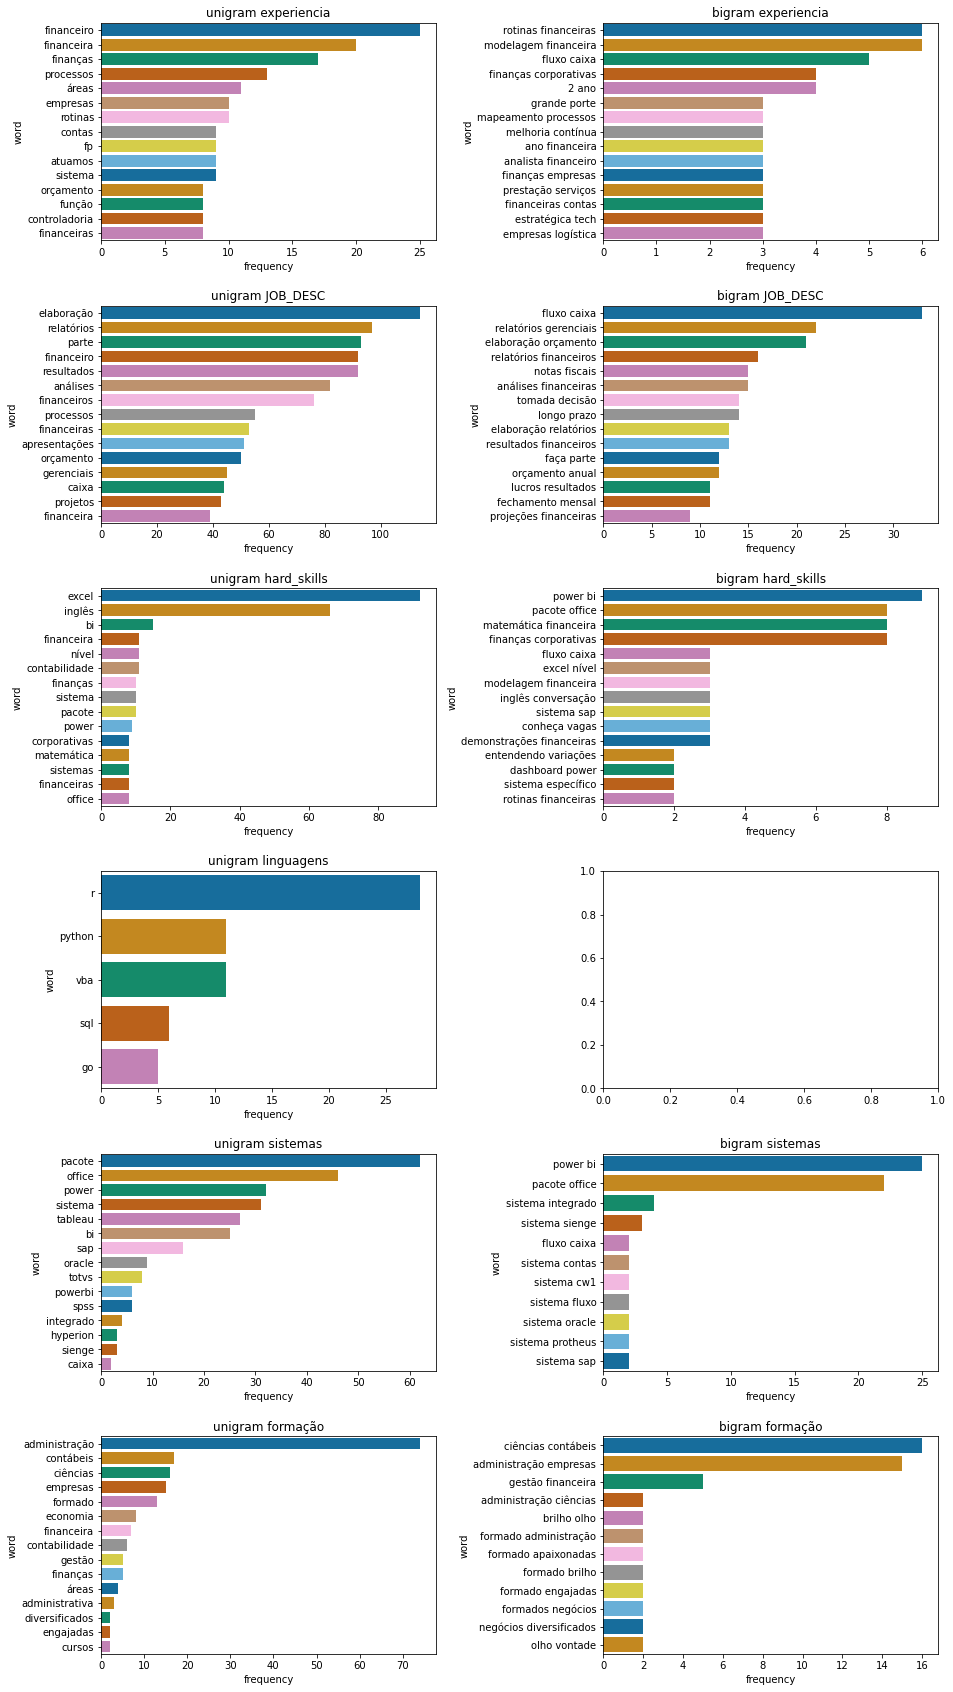

In [17]:
ntipos = list(set(df_skills['tipo']))

fig, axes = plt.subplots(len(ntipos),2,figsize=(15,30))
plt.subplots_adjust(wspace=.5,hspace=.3)
n=0

#gerar um grafico de barras de unigram e outro de bigram para cada tipo de skills extraido
for tipo in ntipos:
    df_plot = df_skills[((df_skills['tipo'] == tipo) & (df_skills['ngram'] == 'unigram'))]
    sns.barplot(ax=axes[n][0],data=df_plot.head(15),x='frequency',y='word',palette='colorblind').set_title(f'unigram {tipo}')
    #Dificilmente teremos um bigram para linguagem de programação
    if tipo != 'linguagens':
        df_plot = df_skills[((df_skills['tipo'] == tipo) & (df_skills['ngram'] == 'bigram'))]
        sns.barplot(ax=axes[n][1],data=df_plot.head(15),x='frequency',y='word',palette='colorblind').set_title(f'bigram {tipo}')
    n+=1

In [18]:
df_skills = pd.DataFrame()

for skill_type in list(set(all_skills['tipo'])):
    for regime in list(set(all_skills['regime'])):
        try:
            result1 = pd.DataFrame()
            result1 = get_frequency(ContV,all_skills[(all_skills['tipo'] == skill_type) & (all_skills['regime'] == regime)]['skills'])
            result1['tipo'] = skill_type
            result1['ngram'] = 'unigram'
            result1['regime'] = regime
            
            result1 = pd.DataFrame()
            result2 = get_frequency(ContV2,all_skills[(all_skills['tipo'] == skill_type) & (all_skills['regime'] == regime)]['skills'])
            result2['tipo'] = skill_type
            result2['ngram'] = 'unigram'
            result2['regime'] = regime
        except: pass
        df_skills = pd.concat([df_skills,result1,result2],ignore_index=True)